In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook",font_scale=1.2)
import pandas as pd
# disable setting with copy warning
pd.options.mode.chained_assignment = None
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import matplotlib.pyplot as plt
import pydicom
# add current dir to path
import sys
base_path = "src/logs_persist/dataset_distillation/distillation_paper"

In [20]:
metrics = (
    f"test/old_subgroupAUROC", f"test/young_subgroupAUROC",
    f"test/female_subgroupAUROC", f"test/male_subgroupAUROC",
    f"test/AUROC"
)

In [21]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    sample_dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        # get last number from directory name
        train_loader_num = int(d.split('_')[-1])
        for seed in seeds:
            #print(os.path.join(d,seed))
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')][0]
            sample_info = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('train_loader')][0]
            results_df = pd.read_csv(os.path.join(d, seed, results))
            sample_df = pd.read_csv(os.path.join(d, seed, sample_info))
            results_df["train_loader_num"] = train_loader_num
            sample_df["train_loader_num"] = train_loader_num
            dfs.append(results_df)
            sample_dfs.append(sample_df)
    return pd.concat(dfs, ignore_index=True), pd.concat(sample_dfs, ignore_index=True)

In [30]:
df_1_fae_large, df_samples_1_fae_large= load_csvs_into_df(base_path+'/2023-11-03 14:14:39-FAE-rsna-balanced-bs32-balanced-dataset-distillation-fullmodel-nsamples1-noDP')
df_1_fae_large["model"] = "FAE_large"

df_fae_small, df_samples_1_rd_small = load_csvs_into_df(base_path+'/2023-11-01 08:50:49-FAE-rsna-balanced-bs32-balanced-dataset-distillation-smallmodel-nsamples1-noDP')
df_fae_small["model"] = "FAE_small"

In [31]:
df_1_fae_large.shape

(8450, 82)

In [32]:
df_fae_small.shape

(816, 81)

In [24]:
min_train_loader_num = min(df_1_fae_large["train_loader_num"].max(), df_fae_small["train_loader_num"].max())
df_1_fae_large = df_1_fae_large.loc[df_1_fae_large["train_loader_num"] <= min_train_loader_num]
df_fae_small = df_fae_small.loc[df_fae_small["train_loader_num"] <= min_train_loader_num]

In [25]:
df_1 = pd.concat([df_1_fae_large, df_fae_small], ignore_index=True)

In [26]:
df = df_1[[*metrics,'model']]
df = pd.melt(df, id_vars=['model'], var_name="metric", value_name="value")
#df.metric = df.metric.str.replace(metrics[1], groups[1])
#df.metric = df.metric.str.replace(metrics[0], groups[0])
df.head()

,model,metric,value
0,FAE_large,test/old_subgroupAUROC,0.59355
1,FAE_large,test/old_subgroupAUROC,0.59410
2,FAE_large,test/old_subgroupAUROC,0.47660
3,FAE_large,test/old_subgroupAUROC,0.56185
4,FAE_large,test/old_subgroupAUROC,0.48945


value                                \
                                     count      mean       std       min   
model     metric                                                           
FAE_large test/AUROC                 816.0  0.532924  0.071809  0.295750   
          test/female_subgroupAUROC  816.0  0.506406  0.061113  0.274150   
          test/male_subgroupAUROC    816.0  0.559443  0.103424  0.278400   
          test/old_subgroupAUROC     816.0  0.557683  0.087323  0.279600   
          test/young_subgroupAUROC   816.0  0.508165  0.067501  0.305800   
FAE_small test/AUROC                 816.0  0.525254  0.070695  0.307975   
          test/female_subgroupAUROC  816.0  0.497063  0.060875  0.293700   
          test/male_subgroupAUROC    816.0  0.553445  0.102151  0.282750   
          test/old_subgroupAUROC     816.0  0.547408  0.084908  0.295250   
          test/young_subgroupAUROC   816.0  0.503101  0.066970  0.299600   

                                                                             
                                          25%       50%       75%       max  
model     metric                                                             
FAE_large test/AUROC                 0.483944  0.544844  0.588475  0.664950  
          test/female_subgroupAUROC  0.470712  0.510725  0.549013  0.637100  
          test/male_subgroupAUROC    0.486875  0.577100  0.645075  0.727950  
          test/old_subgroupAUROC     0.505175  0.571350  0.622475  0.718250  
          test/young_subgroupAUROC   0.459537  0.515450  0.562700  0.659500  
FAE_small test/AUROC                 0.476056  0.535850  0.579244  0.653075  
          test/female_subgroupAUROC  0.462025  0.501025  0.541725  0.642150  
          test/male_subgroupAUROC    0.479863  0.572350  0.637350  0.725900  
          test/old_subgroupAUROC     0.493863  0.559687  0.609737  0.705450  
          test/young_subgroupAUROC   0.457037  0.510225  0.556363  0.651700

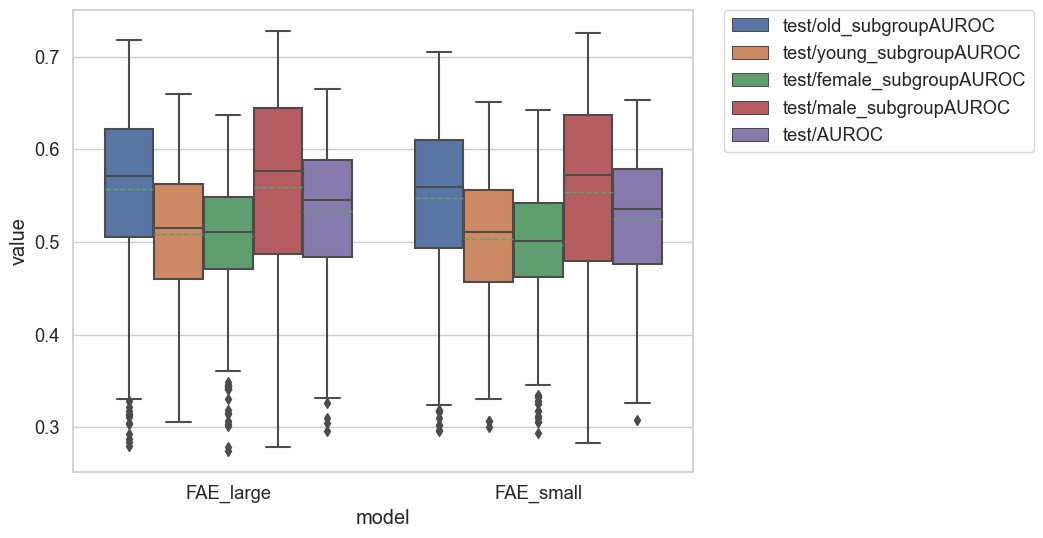

In [27]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="model", y="value", hue="metric", meanline=True, showmeans=True)
# legend outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# get statistics from each metric per model
df.groupby(["model","metric"]).describe()